In [4]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import warnings
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdates
plt.style.use('seaborn')
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
warnings.filterwarnings("ignore")

## Data Preparation

In [5]:
training = pd.read_csv('data/training.csv')
testing = pd.read_csv('data/testing.csv')
training.shape, testing.shape

((14803, 32), (4932, 32))

In [6]:
energy_data= pd.concat([training, testing])
energy_data.shape

(19735, 32)

In [7]:
# drop some unnecessary variables and converse all values to numerial values
train= training.drop(['date','Appliances','Visibility', 'rv1', 'rv2', 'WeekStatus','Day_of_week'], axis=1)
train_half = train.join(pd.get_dummies(training.WeekStatus))
train_full= train_half.join(pd.get_dummies(training.Day_of_week))

In [8]:
train_full.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,NSM,Weekday,Weekend,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,61200,1,0,0,1,0,0,0,0,0
1,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,61800,1,0,0,1,0,0,0,0,0
2,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,62400,1,0,0,1,0,0,0,0,0
3,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,63600,1,0,0,1,0,0,0,0,0
4,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,17.133333,...,64200,1,0,0,1,0,0,0,0,0


In [9]:
test= testing.drop(['date','Appliances','Visibility', 'rv1', 'rv2', 'WeekStatus','Day_of_week'], axis=1)
test_half = test.join(pd.get_dummies(testing.WeekStatus))
test_full= test_half.join(pd.get_dummies(testing.Day_of_week))
test_full.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,NSM,Weekday,Weekend,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,40,19.890000,46.066667,19.200000,44.590000,19.79,45.000000,18.89,45.723333,17.166667,...,63000,1,0,0,1,0,0,0,0,0
1,50,19.890000,45.766667,19.200000,44.500000,19.79,44.900000,18.89,45.790000,17.100000,...,64800,1,0,0,1,0,0,0,0,0
2,70,19.926667,45.863333,19.356667,44.400000,19.79,44.900000,18.89,46.430000,17.100000,...,67200,1,0,0,1,0,0,0,0,0
3,60,20.066667,46.396667,19.426667,44.400000,19.79,44.826667,19.00,46.430000,17.100000,...,67800,1,0,0,1,0,0,0,0,0
4,10,20.566667,53.893333,20.033333,46.756667,20.10,48.466667,19.00,48.490000,17.150000,...,70200,1,0,0,1,0,0,0,0,0


In [10]:
X_train= train_full
y_train=training.Appliances
X_test=test_full
y_test= testing.Appliances

## Linear Regression model

In [11]:
lr= linear_model.LinearRegression()

In [12]:
# Fitting Linear Regression model
lr.fit(X_train, y_train)
y_pred= lr.predict(X_test)

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
RMSE= sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)
MAE= mean_absolute_error(y_test, y_pred)
MAPE= mean_absolute_percentage_error(y_test, y_pred)

In [15]:
print(' RMSE:', RMSE, ' R2:', R2, ' MAE:', MAE, ' MAPE:', MAPE)

 RMSE: 93.2160387421005  R2: 0.15829205082482523  MAE: 51.98273483515084  MAPE: 59.97773058185537


The result showed very high RMSE and low R2, which means this model is not very good for the dataset.

# RFECV

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
model = linear_model.LinearRegression()
k = StratifiedKFold(n_splits=10, random_state=10)
rfecv = RFECV(estimator=model, step=1,cv=k, scoring='neg_mean_squared_error')
X_train['Visibility']= training['Visibility'] # Add Visibility as the 35th feature
rfecv = rfecv.fit(X_train, y_train)

In [22]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 22
Best features : Index(['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T6', 'T8', 'RH_8',
       'T9', 'T_out', 'Windspeed', 'Weekday', 'Weekend', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')


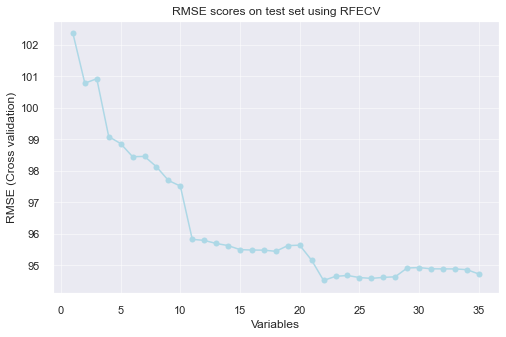

In [23]:
# Plot number of features VS. cross-validation scores RMSE
plt.figure(figsize=(8,5))
plt.xlabel("Variables")
plt.ylabel("RMSE (Cross validation)")
plt.title('RMSE scores on test set using RFECV')

rmse_cv_scores = np.sqrt(-rfecv.grid_scores_)

p = plt.plot(range(1, len(rfecv.grid_scores_) + 1), rmse_cv_scores, marker='o', color='lightblue')
plt.grid(alpha=0.5)
plt.show()

35 predictors (inclusing Visibility) were used to select the best features. Comparing to the original paper, the order of best feature was different and RMSE of my work is around 7 higher. While lights', 'T1', 'RH_1', 'T2', 'RH_2' is my top 5 best feature, the paper' top 5 is NSM, light, Press, RH5 and T3.

# Linegraphs

Text(0, 0.5, 'Appliances Wh')

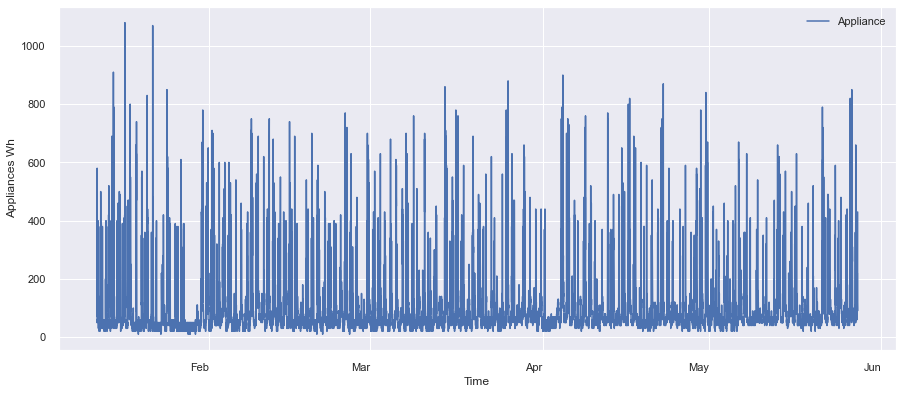

In [16]:
appliances_data=pd.DataFrame({'Date': energy_data['date'],
                            'Appliance': energy_data['Appliances']})
appliances_data.Date= pd.to_datetime(appliances_data.Date)
appliances_data.set_index('Date', inplace=True)

months = mdates.MonthLocator() 
fig, ax = plt.subplots(figsize=(15,7))
appliances_data.plot(ax=ax)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Change the format of x axis into months
plt.xticks(rotation=0)
 # Label x and y
plt.xlabel('Time')
plt.ylabel('Appliances Wh')


In the beginning of February and April, there were days that energy was not used much, while at the middle of January, appliances were used up to more than 1000Wh.

Text(0, 0.5, 'Appliances Wh')

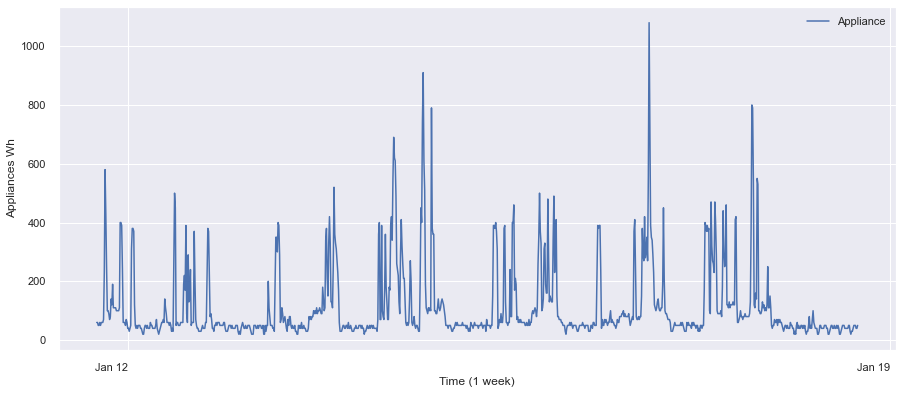

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
appliances_data[appliances_data.index<'2016-01-18 17:00:00'].plot(ax=ax)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) # set format of x axis
plt.xticks(rotation=0)

plt.xlabel('Time (1 week)')
plt.ylabel('Appliances Wh')

It can be seen that there were days that electricity was consumed up to 800 Wh and up.

# Histogram

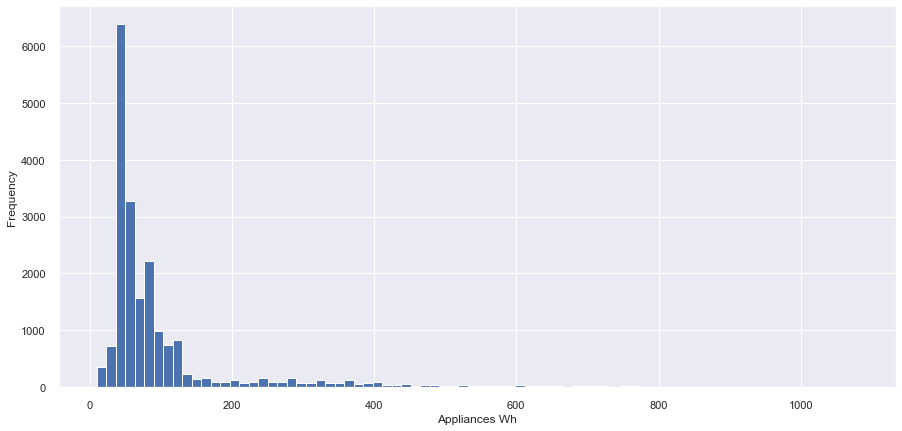

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
plt.hist(appliances_data.Appliance, bins=80)
plt.xlabel("Appliances Wh")
plt.ylabel("Frequency")
plt.show()

# Boxplot

(array([1]), <a list of 1 Text major ticklabel objects>)

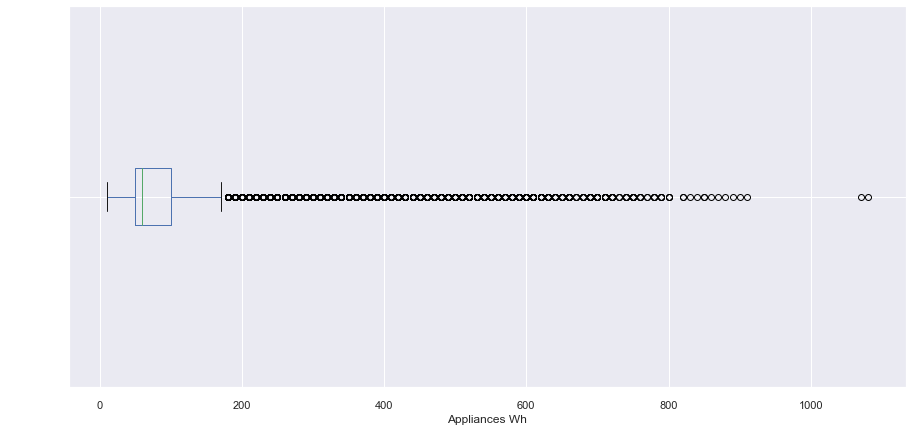

In [19]:
plt.rcParams["figure.figsize"] = (15, 7)
appliances_data.plot.box(vert=False)
plt.xlabel('Appliances Wh')
plt.yticks(color='w')

The common amount of electricity vary from around 5 to 200Wh, with the most common one is 50-60Wh

# Pairplots

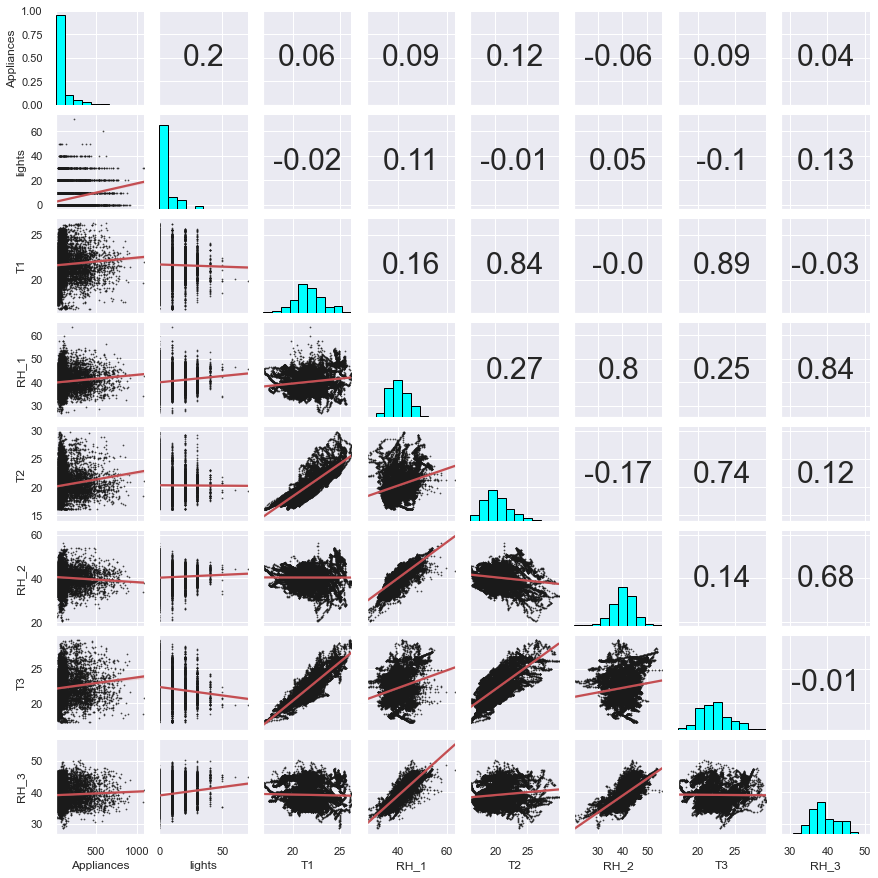

In [20]:
# Plot to explore relationship between the energy consumption of appliances with: lights, T1, RH1, T2, RH2, T3, RH3.
def disp_pearson(x, y, **kws):
    corrmat = np.corrcoef(x,y)
    pearson = round(corrmat[0, 1], 2)
    ax = plt.gca()
    ax.annotate(pearson, [.5, .5], xycoords = "axes fraction", ha = "center", va='center', fontsize = 30)
    
scatterdata = energy_data[['Appliances','lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3']]

s = sns.PairGrid(scatterdata, height =1.5)
s = s.map_diag(plt.hist, color='cyan',edgecolor='black')
s = s.map_lower(sns.regplot, color = 'k', scatter_kws={"s":3}, line_kws={'color' :'r'})
s = s.map_upper(disp_pearson)

It can be seen that there is a positive correlation between the energy consumption of appliances and lights (0.2).
Besides, there is a significant positive correlation between T1 and T2 (0.84), T1 and T3 (0.89), RH1 and RH2 (0.8), RH1 and RH3 (0.84)

# Heatmaps


In [24]:
# Make a new date column from index
appliances_data.reset_index(level=0, inplace=True)

In [25]:
from datetime import date
appliances_data['Week Day'] = appliances_data['Date'].dt.day_name() # get name of Week day

In [26]:
appliances_data['Hour'] = appliances_data['Date'].dt.hour

In [27]:
import datetime
appliances_data['Week_Number'] = appliances_data['Date'].dt.strftime('%U') # get names of weeks in the year

In [28]:
#Create datasets for 4 full weeks
set1=appliances_data[(appliances_data['Week_Number']=='03')]
set2=appliances_data[(appliances_data['Week_Number']=='04')]
set3=appliances_data[(appliances_data['Week_Number']=='05')]
set4=appliances_data[(appliances_data['Week_Number']=='06')]

In [29]:
set1= pd.pivot_table(set1[['Week Day', 'Hour', 'Appliance']], index=['Week Day', 'Hour'], aggfunc='sum')
set1= set1.unstack(level=0)
set1 = set1.reindex(labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1, level=1)

In [30]:
set2= pd.pivot_table(set2[['Week Day', 'Hour', 'Appliance']], index=['Week Day', 'Hour'], aggfunc='sum')
set2= set2.unstack(level=0)
set2 = set2.reindex(labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1, level=1)

In [31]:
set3= pd.pivot_table(set3[['Week Day', 'Hour', 'Appliance']], index=['Week Day', 'Hour'], aggfunc='sum')
set3= set3.unstack(level=0)
set3 = set3.reindex(labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1, level=1)

In [32]:
set4= pd.pivot_table(set4[['Week Day', 'Hour', 'Appliance']], index=['Week Day', 'Hour'], aggfunc='sum')
set4= set4.unstack(level=0)
set4 = set4.reindex(labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1, level=1)

In [33]:
# Change format of day name for short
day_short_names = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

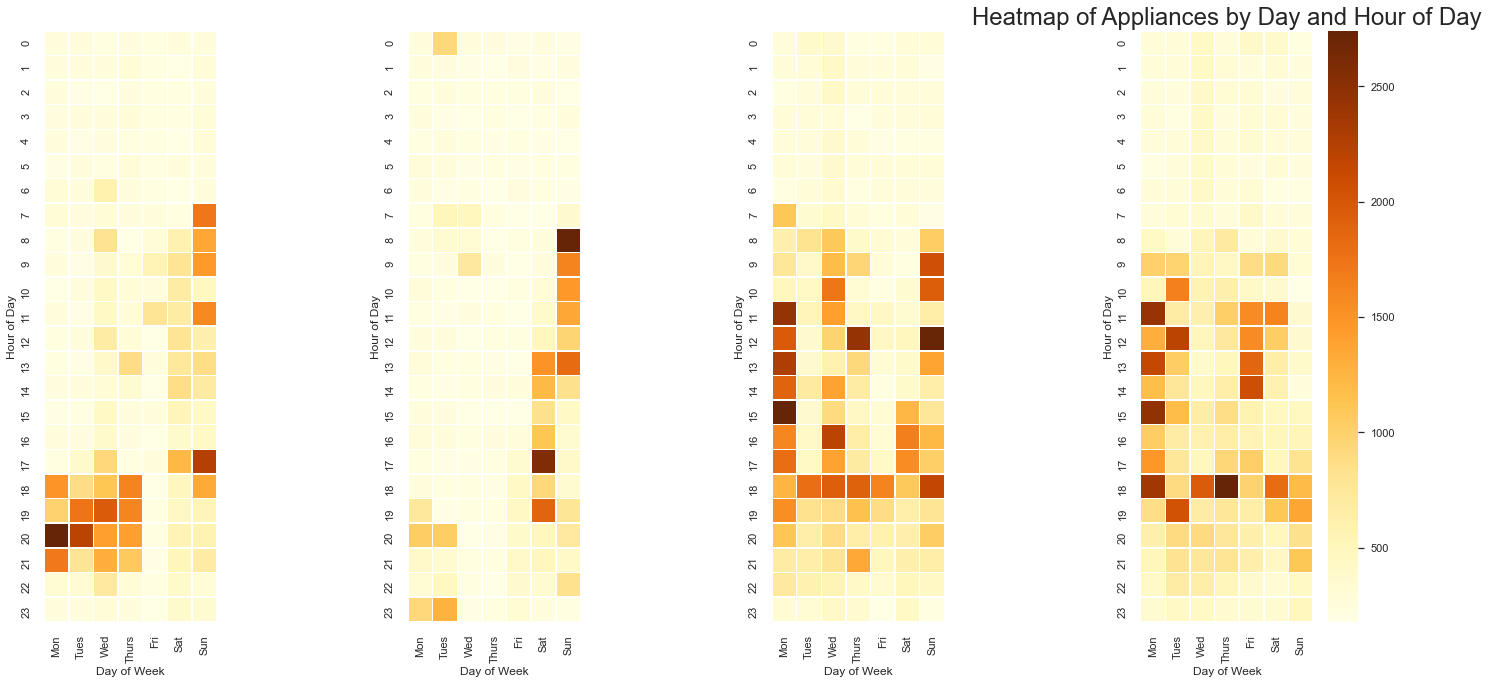

In [34]:
fig = plt.figure(figsize = (25,50)) # width x height
ax1 = fig.add_subplot(4, 4, 1) # row, column, position
ax2 = fig.add_subplot(4, 4, 2)
ax3 = fig.add_subplot(4, 4, 3)
ax4 = fig.add_subplot(4, 4, 4)
sns.heatmap(set1, fmt="d", linewidths=.5,  ax=ax1,cbar=False,cmap="YlOrBr",square=True, xticklabels=day_short_names)
sns.heatmap(set2, fmt="d", linewidths=.5,ax=ax2,cbar=False,cmap="YlOrBr",square=True, xticklabels=day_short_names)
sns.heatmap(set3, fmt="d", linewidths=.5, ax=ax3,cbar=False,cmap="YlOrBr",square=True, xticklabels=day_short_names)
sns.heatmap(set4, fmt="d", linewidths=.5, ax=ax4,cbar=True,cmap="YlOrBr",square=True, xticklabels=day_short_names)

#Set title and labels
plt.title("Heatmap of Appliances by Day and Hour of Day", fontsize=24)
ax1.set(xlabel='Day of Week', ylabel='Hour of Day');
ax2.set(xlabel='Day of Week', ylabel='Hour of Day');
ax3.set(xlabel='Day of Week', ylabel='Hour of Day');
ax4.set(xlabel='Day of Week', ylabel='Hour of Day');
plt.show()

Energy starts to be used at around 6am. The energy consumption decreases from around 9pm. There is no clear pattern in terms of day of the week.

## Conclusion 
In the attemp of reproducing the paper, the result of RFE cross-validation is moderately different from that of the paper. Other than that, all of the remaining work is acceptably alike.